In [1]:
import pandas as pd
from itertools import combinations
import itertools
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from random import randrange
import matplotlib
import seaborn as sns
from itertools import permutations
from scipy.stats import truncnorm
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import os
import zipfile

# Space filling plan

- In this paper, we are using uniform projection (or Latin hypercube sampling)

In [2]:
def uniform_projection_plan(m, n):
    """
    A function for constructing a uniform projection plan for an n-dimensional hypercube 
    with m samples per dimension. 
    It returns a vector of index vectors.
    """
    perms = [np.random.permutation(m) for i in range(n)]
    return np.array([[perms[i][j] for i in range(n)] for j in range(m)])

In [3]:
def pairwise_distances(X, p=2):
    
    m = len(X)
    return [np.linalg.norm(X[i]-X[j], p) for i in range(m-1) for j in range(i+1,m)] 

def phiq(X, q=1, p=2):
    dists = pairwise_distances(X, p)
    return np.sum(np.array([(dist**(-q))**(1/q) for dist in dists]))

In [52]:
### randomly generate some sampling plans and use the one that has the smallest phiq 
### The result will change every time you run the code, and here we share the code to demonstrate how the method works 

m = 726
lim = 1000
n = 50
for i in range(m):
    plans = uniform_projection_plan(n, 6)
    dist = phiq(plans, q=1, p=2)
    if dist <= lim:
        lim = dist
        result = plans 

In [53]:
dist

26.829714424468715

In [105]:
n = 50
cv_lst = np.linspace(3.6, 4.1, n)
T_lst = np.linspace(25, 55, n)
# use log space because we do not want too many data points at the high values 
cc1_lst = np.logspace(-6, 1, num = n, base = 2)
cc2_lst = np.logspace(-6, 1.6, num = n, base = 2)
# ratio_lst = np.linspace(0.1, 5, n)
ocv_lst = np.linspace(0, 7, n)
n_lst = np.linspace(0, 5, n)
params = np.stack((cv_lst, T_lst, cc1_lst, cc2_lst, ocv_lst, n_lst), axis = 1)

param = params[:, 0]
index = result[:, 0]
plans = param[index][:, np.newaxis]
for i in range(1, 6):
    param = params[:, i]
    index = result[:, i]
    new = param[index][:, np.newaxis]
    plans = np.concatenate((plans, new), axis = 1)

However, for current we have to clip the values and for some variables (e.g. Temperature), we don't have the bandwidth to test too many values. I use the "closest" function to find values that are closest to pre-set values in the list. 

(-0.01, 3.0)

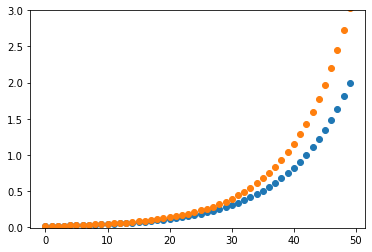

In [226]:
plt.scatter(range(n), np.logspace(-6, 1, num = n, base = 2))
plt.scatter(range(n), np.logspace(-6, 1.6, num = n, base = 2))
plt.ylim([-0.01, 3])

In [104]:
2**(-6)

0.015625

In [8]:
def closest(lst, K):   
    """
    Find the closest value in a list of current values 
    """   
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

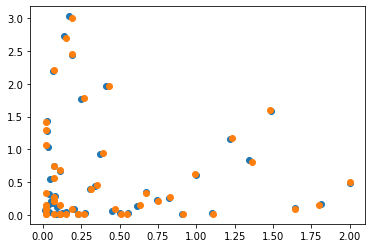

In [106]:
plt.scatter(plans[:,2], plans[:,3])
# CV list 
plans[:, 0] = [round(i,2) for i in plans[:, 0]] 
# Temperature 
plans[:, 1] = [closest([25, 35, 40, 45, 55], i) for i in plans[:, 1]] 
# you want to bound the current values, not above 2C for CC1 and 3C for CC2
plans[:, 2] = [round(closest(np.linspace(0.025, 2, n), i),2) for i in plans[:, 2]]
plans[:, 3] = [round(closest(np.linspace(0.025, 3, n), i),2) for i in plans[:, 3]]
# OCV time 
plans[:, 4] = [closest([0, 3, 7], i) for i in plans[:, 4]]  
# Verification repeats 
plans[:, 5] = [closest([0, 2, 3, 5], i) for i in plans[:, 5]]  
plt.scatter(plans[:,2], plans[:,3])

In [212]:
df_up = pd.DataFrame(plans, columns = ['formation_cutoff_voltage_1', 'formation_temperature', 'formation_charge_current_1', 
                                'formation_charge_current_2', 'ocv_time', 'formation_verification_repeat'])

### Plot two parameters at a time to check the distribution

Text(0, 0.5, 'CC$_{2}/A$')

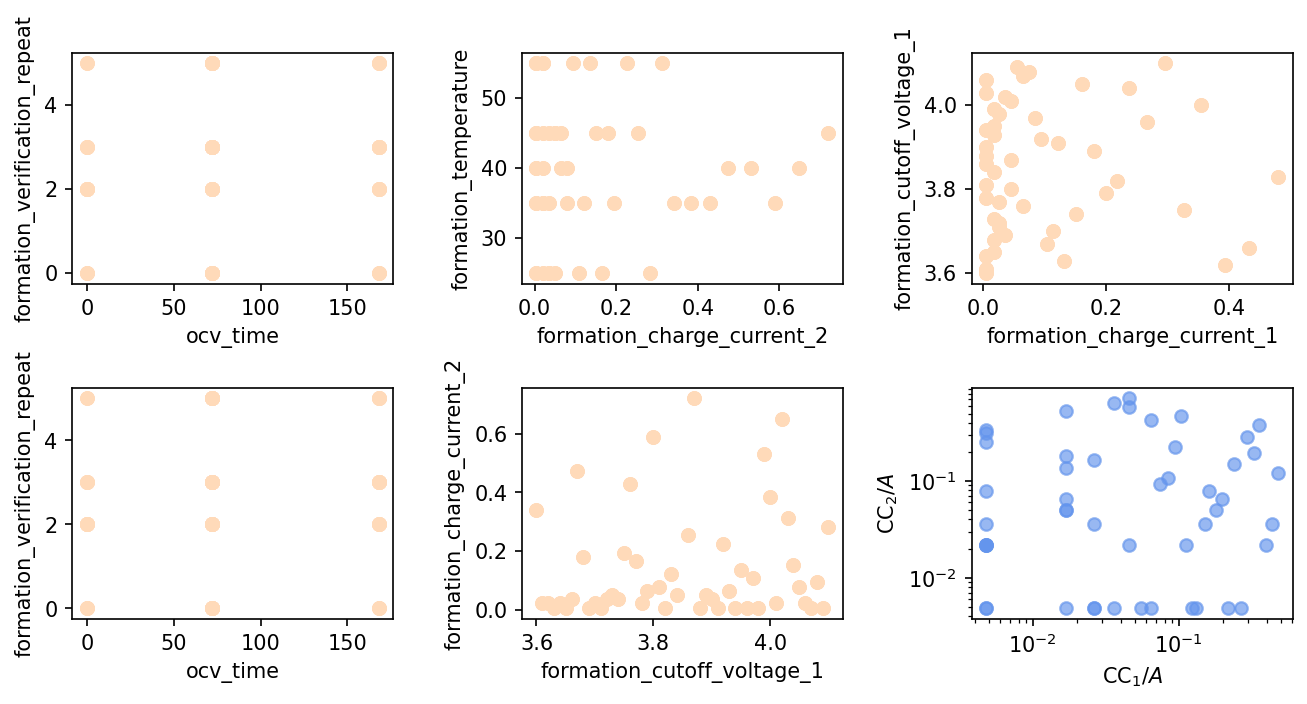

In [13]:
num_rows = 2
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*3.5, num_rows*2.5), dpi = 150)

fig.subplots_adjust(hspace = .45, wspace=.4)
axs = axs.ravel()

cols = ['formation_cutoff_voltage_1', 'formation_temperature',
       'formation_charge_current_1', 'formation_charge_current_2', 'ocv_time', 'formation_verification_repeat']

# for i in range(len(cols)):
#     col = cols[i]
#     col2 = cols[len(cols)-1-i]
#     axs[i].scatter(df_up[col], df_up[col2])
#     axs[i].set_xlabel(col)
#     axs[i].set_ylabel(col2)

for i in range(5):
    cols_samp = random.sample(cols, 2)
    axs[i].scatter(df_up[cols_samp[0]], df_up[cols_samp[1]], color = 'peachpuff')
    axs[i].set_xlabel(cols_samp[0])
    axs[i].set_ylabel(cols_samp[1])
    
# axs[2].plot(df_up[cols[2]], df_up[cols[2]], linestyle = '--', color = 'orange')
axs[5].scatter(df_up[cols[2]], df_up[cols[3]], color = 'cornflowerblue', alpha = 0.3)
axs[5].set_yscale("log")
axs[5].set_xscale("log")
axs[5].set_xlabel("CC$_{1}/A$")
axs[5].set_ylabel("CC$_{2}/A$")

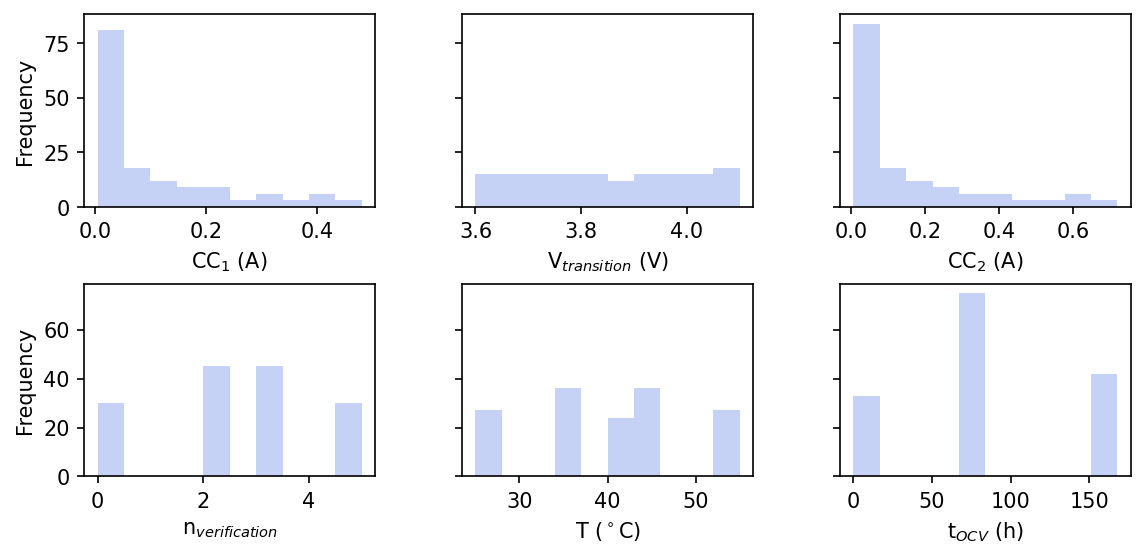

In [4]:
num_rows = 2
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*2), dpi = 150, sharey = 'row')

fig.subplots_adjust(hspace = .4, wspace=.3)
axs = axs.ravel()

names = [  "CC$_{1}$ (A)", "V$_{transition}$ (V)", "CC$_{2}$ (A)", 'n$_{verification}$', 'T ($^\circ$C)', 't$_{OCV}$ (h)']
i = 0
for col in df_up.columns:
    df_up[col].hist(ax = axs[i], color = 'royalblue', grid = False, alpha = 0.3)
    axs[i].set_xlabel(names[i])
    if (i == 0) or (i == 3):
        axs[i].set_ylabel('Frequency')
    i += 1
    
# plt.savefig('batch_1_hist.pdf', transparent = True, bbox_inches='tight')

<AxesSubplot:>

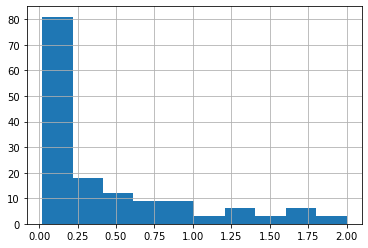

In [221]:
### C-rate distribution
(df['formation_charge_current_1']/0.24).hist()